Mostly derived from `2016Oct-MMTHecto`

In [1]:
# This changes the current directory to the base saga directory - make sure to run this first!
# This is necessary to be able to import the py files and use the right directories,
# while keeping all the notebooks in their own directory.
import os
import sys

if 'saga_base_dir' not in locals():
    saga_base_dir = os.path.abspath('..')

if saga_base_dir not in sys.path:
    os.chdir(saga_base_dir)

In [2]:
from __future__ import print_function, division

from collections import Counter, OrderedDict

import hosts
import targeting
import mmthecto
import numpy as np

from astropy import units as u
from astropy.coordinates import *
from astropy import table
from astropy.visualization import hist as ahist

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import patches

rcParams['image.interpolation'] = 'none'
rcParams['figure.figsize'] = (16, 10)
plt.rcParams['image.cmap'] = 'viridis'

from IPython import display

In [4]:
DATESUFFIX = 'jan2017'

In [5]:
proposed_targets = [145729, #othello
                    161174] #scooby doo

# Choose hosts and Load stuff

In [6]:
hostlst = hosts.get_saga_hosts_from_google() #'named' hosts

Using cached version of google hosts list from file "hosts_dl.pkl2"


In [7]:
hosts_to_target = []
for nsanum in proposed_targets:
    for h in hostlst:
        if h.nsaid == nsanum:
            hosts_to_target.append(h)
            break
    else:
        # new target
        hosts_to_target.append(hosts.NSAHost(nsanum))
hosts_to_target

[<hosts.NSAHost object w/ name 'Othello' AKA: ['NGC5792', 'NSA145729']>,
 <hosts.NSAHost object w/ name 'ScoobyDoo' AKA: ['NGC4158', 'NSA161174']>]

In [8]:
# now set to the latest base catalogs
for h in hosts_to_target:
    h.fnsdss = 'SAGADropbox/base_catalogs/base_sql_nsa{0}.fits.gz'.format(h.nsaid)
    h._cached_sdss = None

In [9]:
# actually make sure they're loaded
torem = []
for h in hosts_to_target:
    try:
        h.get_sdss_catalog()
    except IOError:
        torem.append(h)
        print('Failed to load base catalog for', h, 'so removing from hosts_to_target')
        
hosts_to_target_orig = hosts_to_target[:]
for h in torem:
    hosts_to_target.remove(h)

In [10]:
# preview the catalog
hosts_to_target[0].get_sdss_catalog()

OBJID,RA,DEC,PHOTPTYPE,PHOT_SG,FLAGS,clean,SATURATED,BAD_COUNTS_ERROR,BINNED1,TOO_FEW_GOOD_DETECTIONS,u,g,r,i,z,u_err,g_err,r_err,i_err,z_err,MODELMAGERR_U,MODELMAGERR_G,MODELMAGERR_R,MODELMAGERR_I,MODELMAGERR_Z,EXTINCTION_U,EXTINCTION_G,EXTINCTION_R,EXTINCTION_I,EXTINCTION_Z,DERED_U,DERED_G,DERED_R,DERED_I,DERED_Z,PETRORAD_U,PETRORAD_G,PETRORAD_R,PETRORAD_I,PETRORAD_Z,PETRORADERR_U,PETRORADERR_G,PETRORADERR_R,PETRORADERR_I,PETRORADERR_Z,DEVRAD_U,DEVRADERR_U,DEVRAD_G,DEVRADERR_G,DEVRAD_R,DEVRADERR_R,DEVRAD_I,DEVRADERR_I,DEVRAD_Z,DEVRADERR_Z,DEVAB_U,DEVAB_G,DEVAB_R,DEVAB_I,DEVAB_Z,CMODELMAG_U,CMODELMAGERR_U,CMODELMAG_G,CMODELMAGERR_G,CMODELMAG_R,CMODELMAGERR_R,CMODELMAG_I,CMODELMAGERR_I,CMODELMAG_Z,CMODELMAGERR_Z,PSFMAG_U,PSFMAGERR_U,PSFMAG_G,PSFMAGERR_G,PSFMAG_R,PSFMAGERR_R,PSFMAG_I,PSFMAGERR_I,PSFMAG_Z,PSFMAGERR_Z,FIBERMAG_U,FIBERMAGERR_U,FIBERMAG_G,FIBERMAGERR_G,FIBERMAG_R,FIBERMAGERR_R,FIBERMAG_I,FIBERMAGERR_I,FIBERMAG_Z,FIBERMAGERR_Z,FRACDEV_U,FRACDEV_G,FRACDEV_R,FRACDEV_I,FRACDEV_Z,Q_U,U_U,Q_G,U_G,Q_R,U_R,Q_I,U_I,Q_Z,U_Z,EXPAB_U,EXPRAD_U,EXPPHI_U,EXPAB_G,EXPRAD_G,EXPPHI_G,EXPAB_R,EXPRAD_R,EXPPHI_R,EXPAB_I,EXPRAD_I,EXPPHI_I,EXPAB_Z,EXPRAD_Z,EXPPHI_Z,FIBER2MAG_R,FIBER2MAGERR_R,EXPMAG_R,EXPMAGERR_R,PETROR50_R,PETROR90_R,PETROMAG_R,SB_EXP_R,SB_PETRO_R,J,JERR,H,HERR,K,KERR,survey,SPEC_Z,SPEC_Z_ERR,SPEC_Z_WARN,PHOTOZ,PHOTOZ_ERR,W1,W1ERR,W2,W2ERR,HOST_RA,HOST_DEC,HOST_DIST,HOST_VHOST,HOST_MK,HOST_MR,HOST_MG,HOST_NSAID,HOST_SAGA_NAME,RHOST_ARCM,RHOST_KPC,OBJ_NSAID,SATS,PROBABILITY_CLASS1,RESCALED_PROBABILITY_CLASS1,REMOVE,TELNAME,MASKNAME,ZQUALITY,SPEC_CLASS,SPECOBJID,SPEC_REPEAT,SPEC_SN,SPEC_HA_EW,SPEC_HA_EWERR,Ai,fibermag_z,rhost,fibermag_r,fibermag_u,Ag,fibermag_i,Az,Ar,dec,Au,fibermag_g,type,ra,objID,psf_r,psf_u,psf_z,rhost_kpc,phot_sg,psf_g,psf_i,U,B,V,R,I,psf_U,psf_B,psf_V,psf_R,psf_I
int64,float64,float64,int16,str40,int64,int32,int64,int64,int64,int64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float32,float32,float32,float32,float32,float32,str32,float32,float32,int32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str48,float64,float64,int64,int64,float64,float64,int64,str6,str48,int64,str2,str48,str48,float64,float64,float64,float32,float32,float64,float32,float32,float32,float32,float32,float32,float64,float32,float32,int16,float64,int64,float32,float32,float32,float64,str40,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
1237648702984553212,224.682556757,-1.13757241905,6,STAR,193583034531856,1,0,0,268435456,0,23.5198,22.996,21.6748,20.8024,20.2799,0.480243,0.152544,0.0725211,0.0564013,0.116342,0.480243,0.152544,0.0725211,0.0564013,0.116342,0.317537,0.233641,0.169456,0.128493,0.0911033,23.2022,22.7624,21.5053,20.6739,20.1888,0.0915941,0.912516,1.33508,1.11026,0.917497,0.0543432,0.0970901,0.312111,0.138869,0.093988,4.10633,10.1499,0.0269676,10.4693,0.147914,0.296628,0.121973,0.188774,2.39175e-05,0.0247856,0.117926,0.349434,0.796322,0.107736,0.951787,22.2076,0.415689,23.0523,0.15096,21.6608,0.106484,20.8115,0.0560025,20.3

In [11]:
# these are the already-observed objects
spectra = h.load_and_reprocess_sdss_catalog('SAGADropbox/data/saga_spectra_clean.fits.gz')

# Ranking 

rank | desc
--- | ---
1 | Flux Stars
2 | Special targets
3 | r<300 kpc, ugri cuts, M_r<20
4 | r<300 kpc, ugri cuts, M_r<20.75
5 | r<300 kpc, gri cuts, M_r<20.75
6 | 300<r<450 kpc, ugri cuts, M_r<20.75
7 | 300<r<450 kpc, gri cuts, M_r<20.75
8 | other

The ugr cut is:  $ u-g > 1.5(g-r) - 0.25$
(that's the *cut*, not the accept condition)

## Fix up wrong-distance hosts if need be

In [12]:
for h in hosts_to_target:
    fix = False
    cat = h.get_sdss_catalog()
    if np.median(cat['RHOST_KPC']) > 600:
        print('RHOST distances wrong for', h)
        fix = 1
    if np.abs(np.median(cat['HOST_DIST'])-h.distmpc)/h.distmpc > 0.05:
        print('HOST_DIST wrong on', h)
        fix = 2
        
    if fix:
        scs = SkyCoord(cat['RA'], cat['DEC'], unit=u.deg)
        cat['RHOST_ARCM'] = scs.separation(h.coords).to(u.arcmin).value
        cat['RHOST_KPC'] = scs.separation(h.coords).to(u.radian).value * h.distmpc*1000

In [13]:
def rank_targets(cat, ugoffset=-0.25):
    corrmag = {band: cat[band] - cat['A'+band]  for band in 'ugri'}
    
    phot_good = (cat['r']<21.25)& (cat['fibermag_r']<23)&(cat['phot_sg']=='GALAXY')
    
    gmr_wunc = corrmag['g']- corrmag['r'] - 2*np.hypot(cat['g_err'], cat['r_err'])
    rmi_wunc = corrmag['r']- corrmag['i'] - 2*np.hypot(cat['g_err'], cat['r_err'])
    
    gmr_accept = gmr_wunc < 0.85
    rmi_accept = rmi_wunc < 0.55
    if ugoffset is None:
        # this is a *cut*, meaning True means get rid of it
        ug_cut = np.zeros_like(gmr_accept)
    else:
        ug_cut = corrmag['u'] - corrmag['g'] < (1.5*(corrmag['g'] - corrmag['r']) + ugoffset)
    
    gri_accept  = gmr_accept&gmr_accept
    ugri_accept  = gri_accept&~ug_cut
    
    r_bright = corrmag['r'] < 20.
    r_ok = corrmag['r'] < 20.75
    r_faint = r_ok&~r_bright
    
    near = cat['RHOST_KPC']<300
    nearish = (cat['RHOST_KPC']<450) & ~near
    
    ranks = np.zeros(len(cat), dtype=int)
    
    
    ranks[r_ok & gri_accept & nearish & phot_good] = 7
    ranks[r_ok & ugri_accept & nearish & phot_good] = 6
    ranks[r_ok & gri_accept & near & phot_good] = 5
    ranks[r_ok & ugri_accept & near & phot_good] = 4
    ranks[r_bright & ugri_accept & near & phot_good] = 3
    
    ranks[(ranks==0)&phot_good] = 8  # other
    
    do_checks(cat, ranks)
    
    return ranks

def do_checks(cat, ranks):
    
    zq = cat['ZQUALITY'].copy()
    # ranks ~-100 are removed due to already-observed
    havespec = zq>=3
    ranks[havespec] = -100 - zq[havespec]
    
    # this *shouldn't* be necessary, as ZQUALITY should be in the base catalog.  
    # But as a sanity check we look to see if anything in the spectral catalog is still being included
    spec_this_host = spectra[spectra['HOST_NSAID']==h.nsaid]
    spec_this_host = spec_this_host[np.in1d(spec_this_host['OBJID'], cat['OBJID'])]

    for i, zqi in zip(spec_this_host['OBJID'], spec_this_host['ZQUALITY']):
        zq[cat['OBJID']==i] = zqi
    if np.any(ranks[zq>2]>=0):
        print('POSSIBLE PROBLEM: Found some objects in spectrum list that are *not* claimed ' 
              'as having spectra in the base catalogs.  Setting them to -11x:', dict(Counter(ranks[ranks<-110])))
        ranks[zq>2] = -110 - zq[zq>2]
    
    # remove list
    tokeep = cat['REMOVE']==-1
    ranks[~tokeep] = -cat['REMOVE'][~tokeep] # sets the REMOVE objects to -their remove value
    remmskval =  np.min(ranks)-1
    # remove anything in the remove list online but not in the catalog as remove
    ranks[~targeting.remove_targets_with_remlist(cat, h, maskonly=True, verbose='warning')&(ranks>-1)] = remmskval
    if np.sum(ranks==remmskval) > 0:
        print('Removed', np.sum(ranks==remmskval), 'due to online remove list. Remmsk val:', remmskval)
    
    #de-duplicate
    if len(np.unique(cat['OBJID'])) != len(cat):
        _, idxs = np.unique(cat['OBJID'], return_index=True)
        msk = np.ones_like(cat, dtype=bool)
        msk[idxs] = 0
        ranks[msk] = -1000
        
        print('WARNING: some duplicate objid found.  Setting', np.sum(ranks==-1000), 'dupes to pri=-1000')


In [14]:
for h in hosts_to_target:
    print('On host', h.name)
    cat = h.get_sdss_catalog()

    cat['mmt_ranks'] = rank_targets(cat)
    
    counter = Counter(cat['mmt_ranks'])
    t = table.Table()
    t['rank'] = sorted(counter)[::-1]
    t['count'] = [counter[r] for r in t['rank']]
    display.display(display.HTML(t._repr_html_()))

On host Othello


rank,count
int64,int64
8,7510
7,635
6,993
5,470
4,403
3,208
0,73878
-1,8
-2,237


On host ScoobyDoo


rank,count
int64,int64
8,8898
7,331
6,660
5,216
4,223
3,196
0,57943
-1,5
-2,191


# Plot catalogs w/ ranks 

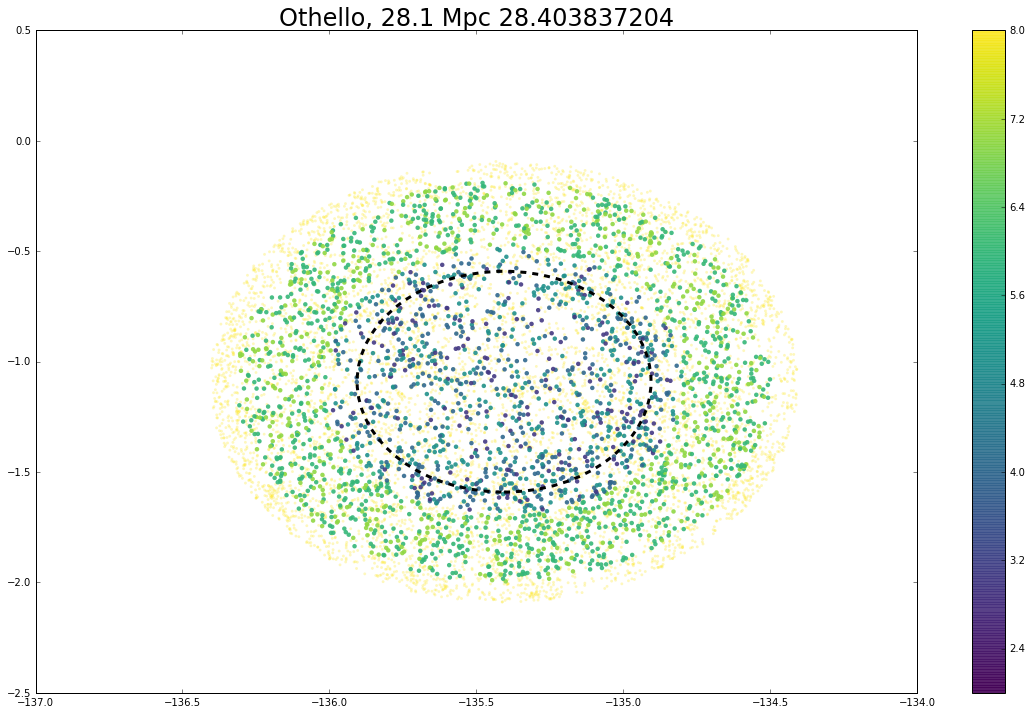

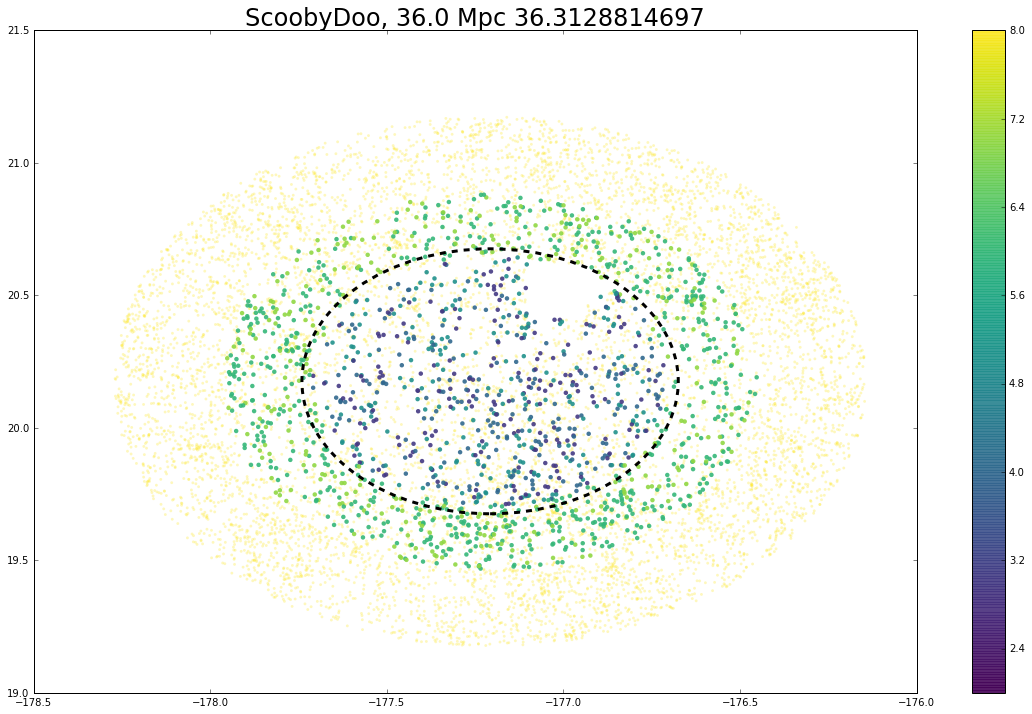

In [15]:
for h in hosts_to_target:
    cat = h.get_sdss_catalog()
    ranks = cat['mmt_ranks']

    plt.figure()
    
    msk_good = (ranks>1)&(ranks<8)
    msk_bad = (ranks>7)
    
    ras = Angle(cat['ra'], u.deg).wrap_at(180*u.deg)
    decs = cat['dec']
    
    plt.scatter(ras[msk_bad], decs[msk_bad], 
                lw=0, alpha=.3, c=ranks[msk_bad],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(ras[msk_good], decs[msk_good], 
                lw=0, alpha=.9, c=ranks[msk_good],s=20, vmin=2, vmax=np.max(ranks))
    
    plt.colorbar()
    
    ell = patches.Ellipse((Angle(h.ra, u.deg).wrap_at(180*u.deg).value, h.dec),
                          1./np.cos(np.radians(h.dec)), 1,
                         fc='none', ec='k', lw=3, ls='--')
    plt.gca().add_patch(ell)
    
    
    plt.title('{}, {:.1f} {}'.format(h.name, h.dist, np.unique(cat['HOST_DIST'])[0]), fontsize=24)
    
    plt.tight_layout()

In [21]:
needmorefluxstars = [161174]

generated_cats = {}
for h in hosts_to_target:
    if generated_cats:
        print('') # makes a newline except for on the first one
    print('On host', h.name)
    sys.stdout.flush()

    cat = h.get_sdss_catalog()
    ranks = cat['mmt_ranks']
    
    fnout = 'mmthecto/{0}_{1}.cat'.format(h.name, DATESUFFIX)
    fluxfnout = fnout.replace('.cat', '.fluxstars')
    print('Going to write', fnout)
    
    msk = (cat['RHOST_ARCM']<40) & (ranks>0) & (ranks<8)
    
    if h.nsaid in needmorefluxstars:
        fluxrng = (17., 18.)
        removefluxdistance = (20*u.arcsec, ranks[msk]<6)
    else:
        fluxrng = (17., 17.7)
        removefluxdistance = (40*u.arcsec, ranks[msk]<6)
    
    generated_cats[h] = mmthecto.generate_catalog(h, cat[msk], ranks[msk],
                                                  fnout=fnout, fluxfnout=fluxfnout,
                                                  repeatflux=4, fluxrng=fluxrng,
                                                  removefluxdistance=removefluxdistance)

On host Othello
Going to write mmthecto/Othello_jan2017.cat
Including 1359 targets
Found 231 Flux stars
Removing 29 Flux stars too close to program stars
Final flux star count: 202 and 33 are in 1 deg FOV
Found 468 guide stars

On host ScoobyDoo
Going to write mmthecto/ScoobyDoo_jan2017.cat
Including 1422 targets
Found 113 Flux stars
Removing 4 Flux stars too close to program stars
Final flux star count: 109 and 28 are in 1 deg FOV
Found 192 guide stars


## Inspect the flux stars to be sure there are enough

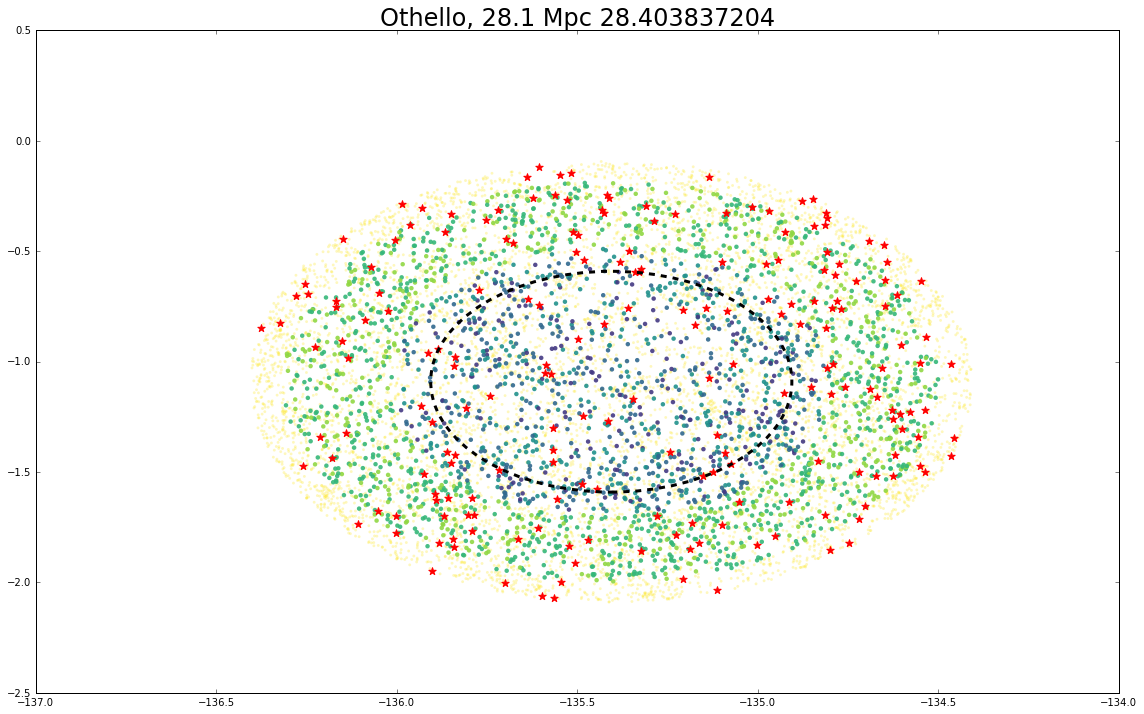

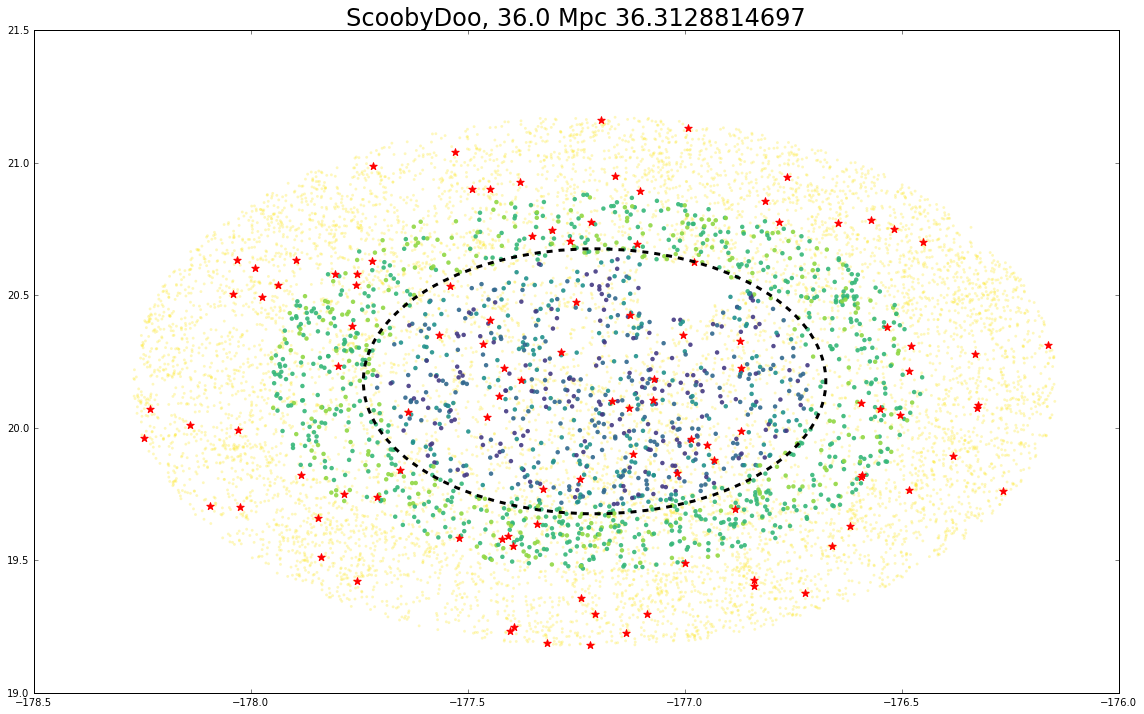

In [22]:
for h in [h for h in hosts_to_target if h.nsaid in proposed_targets]:
    cat = h.get_sdss_catalog()
    gcat = generated_cats[h]
    ranks = cat['mmt_ranks']
    
    fstars = gcat[gcat['rank']=='1'][::4]

    plt.figure()
    
    msk_good = (ranks>1)&(ranks<8)
    msk_bad = (ranks>7)
    
    ras = Angle(cat['ra'], u.deg).wrap_at(180*u.deg)
    decs = cat['dec']
    
    plt.scatter(ras[msk_bad], decs[msk_bad], 
                lw=0, alpha=.3, c=ranks[msk_bad],s=8, vmin=2, vmax=np.max(ranks))
    plt.scatter(ras[msk_good], decs[msk_good], 
                lw=0, alpha=.9, c=ranks[msk_good],s=20, vmin=2, vmax=np.max(ranks))
    
    fra = Angle(fstars['ra'], u.deg).wrap_at(180*u.deg)
    fdec = Angle(fstars['dec'], u.deg)
    plt.scatter(fra, fdec, color='r', s=60, marker='*')
    
    ell = patches.Ellipse((Angle(h.ra, u.deg).wrap_at(180*u.deg).value, h.dec),
                          1./np.cos(np.radians(h.dec)), 1,
                         fc='none', ec='k', lw=3, ls='--')
    plt.gca().add_patch(ell)
    
    
    plt.title('{}, {:.1f} {}'.format(h.name, h.dist, np.unique(cat['HOST_DIST'])[0]), fontsize=24)
    
    plt.tight_layout()